In [1]:
from datetime import datetime
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Data Wrangling - Supplementary Datasets

In [2]:
passenger_volume = pd.read_excel(
    "Supplementary Datasets\Passenger Volume for Delta Air Lines.xlsx"
)
passenger_volume = passenger_volume.loc[(passenger_volume["Month"] != "TOTAL")]
passenger_volume = passenger_volume.loc[(passenger_volume["Year"] >= 2010)]
passenger_volume.reset_index(drop=True, inplace=True)
passenger_volume["Date"] = pd.to_datetime(
    passenger_volume["Month"].astype(str) + "-" + passenger_volume["Year"].astype(str)
)
passenger_volume = passenger_volume[["Date", "TOTAL"]]
passenger_volume.rename(columns={"TOTAL": "Passenger Volume"}, inplace=True)
passenger_volume.head()

,Date,Passenger Volume
0,2010-01-01,7702695
1,2010-02-01,7167302
2,2010-03-01,9326281
3,2010-04-01,8904471
4,2010-05-01,9256936


In [3]:
rpm = pd.read_excel(
    "Supplementary Datasets\Revenue Passenger Miles for Delta Air Lines.xlsx"
)
rpm = rpm.loc[(rpm["Month"] != "TOTAL")]
rpm = rpm.loc[(rpm["Year"] >= 2010)]
rpm.reset_index(drop=True, inplace=True)
rpm["Date"] = pd.to_datetime(rpm["Month"].astype(str) + "-" + rpm["Year"].astype(str))
rpm = rpm[["Date", "TOTAL"]]
rpm.rename(columns={"TOTAL": "RPM"}, inplace=True)
rpm.head()

,Date,RPM
0,2010-01-01,11610071
1,2010-02-01,10437347
2,2010-03-01,13464894
3,2010-04-01,12682997
4,2010-05-01,13831522


In [4]:
asm = pd.read_excel(
    "Supplementary Datasets\Available Seat Miles for Delta Air Lines.xlsx"
)
asm = asm.loc[(asm["Month"] != "TOTAL")]
asm = asm.loc[(asm["Year"] >= 2010)]
asm.reset_index(drop=True, inplace=True)
asm["Date"] = pd.to_datetime(asm["Month"].astype(str) + "-" + asm["Year"].astype(str))
asm = asm[["Date", "TOTAL"]]
asm.rename(columns={"TOTAL": "ASM"}, inplace=True)
asm.head()

,Date,ASM
0,2010-01-01,14976718
1,2010-02-01,13486049
2,2010-03-01,15865032
3,2010-04-01,15131974
4,2010-05-01,16302911


In [5]:
fares_cpi = pd.read_excel(
    "Supplementary Datasets\Average Airline Fares in U.S. Cities.xlsx"
)
fares_cpi = fares_cpi.iloc[:, :-2]
fares_cpi_temp = pd.DataFrame(columns=["Year", "Month", "CPI"])
for index, row in fares_cpi.iterrows():
    for column in range(1, len(row)):
        fares_cpi_temp = pd.concat(
            [
                fares_cpi_temp,
                pd.DataFrame(
                    [[int(row.iloc[0]), fares_cpi.columns[column], row.iloc[column]]],
                    columns=["Year", "Month", "CPI"],
                ),
            ]
        )
fares_cpi = fares_cpi_temp
fares_cpi["Date"] = pd.to_datetime(
    fares_cpi["Month"] + " " + fares_cpi["Year"].astype(str)
)
fares_cpi = fares_cpi[["Date", "CPI"]]
fares_cpi.head()

,Date,CPI
0,2010-01-01,264.331
0,2010-02-01,265.358
0,2010-03-01,269.377
0,2010-04-01,275.696
0,2010-05-01,281.740


In [6]:
airlines_ppi = pd.read_excel(
    "Supplementary Datasets\Producer Price Index by Industry Scheduled Passenger Air Transportation.xls"
)
airlines_ppi["observation_date"] = pd.to_datetime(airlines_ppi["observation_date"])
airlines_ppi.rename(
    columns={"observation_date": "Date", "PCU481111481111": "PPI"}, inplace=True
)
airlines_ppi.head()

,Date,PPI
0,2010-01-01,250.9
1,2010-02-01,249.3
2,2010-03-01,255.5
3,2010-04-01,259.9
4,2010-05-01,255.0


In [7]:
fuel_prices = pd.read_excel(
    "Supplementary Datasets\Kerosene-Type Jet Fuel Prices U.S. Gulf Coast.xls"
)
fuel_prices = fuel_prices.loc[
    (fuel_prices["observation_date"] >= datetime(2010, 1, 1))
    & (fuel_prices["observation_date"] <= datetime(2019, 12, 31))
]
fuel_prices["observation_date"] = pd.to_datetime(fuel_prices["observation_date"])
fuel_prices.sort_values(by="observation_date", inplace=True, ascending=True)
fuel_prices.reset_index(drop=True, inplace=True)
fuel_prices.rename(
    columns={"observation_date": "Date", "MJFUELUSGULF": "Fuel Price"}, inplace=True
)
fuel_prices.head()

,Date,Fuel Price
0,2010-01-01,2.052
1,2010-02-01,1.989
2,2010-03-01,2.108
3,2010-04-01,2.243
4,2010-05-01,2.063


In [8]:
hourly_earnings = pd.read_excel(
    "Supplementary Datasets\Average Hourly Earnings of All Employees, Trade, Transportation, and Utilities.xls"
)
hourly_earnings["observation_date"] = pd.to_datetime(
    hourly_earnings["observation_date"]
)
hourly_earnings.rename(
    columns={"observation_date": "Date", "CEU4000000003": "Hourly Earnings"},
    inplace=True,
)
hourly_earnings.head()

,Date,Hourly Earnings
0,2010-01-01,19.58
1,2010-02-01,19.62
2,2010-03-01,19.55
3,2010-04-01,19.66
4,2010-05-01,19.67


In [9]:
employee_counts = pd.read_excel(
    "Supplementary Datasets\All Employees, Trade, Transportation, and Utilities.xls"
)
employee_counts["observation_date"] = pd.to_datetime(
    employee_counts["observation_date"]
)
employee_counts.rename(
    columns={"observation_date": "Date", "CEU4000000001": "Employees"}, inplace=True
)
employee_counts.head()

,Date,Employees
0,2010-01-01,24237
1,2010-02-01,24037
2,2010-03-01,24167
3,2010-04-01,24261
4,2010-05-01,24431


In [10]:
search_activity = pd.read_csv(
    "Supplementary Datasets\Delta Air Lines Google Search Activity.csv"
)
search_activity["Date"] = pd.to_datetime(search_activity["Month"])
search_activity = search_activity[["Date", "Delta Air Lines: (Worldwide)"]]
search_activity.rename(
    columns={"Delta Air Lines: (Worldwide)": "Search Activity"}, inplace=True
)
search_activity.head()

,Date,Search Activity
0,2010-01-01,78
1,2010-02-01,89
2,2010-03-01,88
3,2010-04-01,91
4,2010-05-01,90


In [11]:
data = pd.merge(passenger_volume, rpm, on="Date")
data = pd.merge(data, asm, on="Date")
data = pd.merge(data, fares_cpi, on="Date")
data = pd.merge(data, airlines_ppi, on="Date")
data = pd.merge(data, fuel_prices, on="Date")
data = pd.merge(data, hourly_earnings, on="Date")
data = pd.merge(data, employee_counts, on="Date")
data = pd.merge(data, search_activity, on="Date")
data.head()

,Date,Passenger Volume,RPM,ASM,CPI,PPI,Fuel Price,Hourly Earnings,Employees,Search Activity
0,2010-01-01,7702695,11610071,14976718,264.331,250.9,2.052,19.58,24237,78
1,2010-02-01,7167302,10437347,13486049,265.358,249.3,1.989,19.62,24037,89
2,2010-03-01,9326281,13464894,15865032,269.377,255.5,2.108,19.55,24167,88
3,2010-04-01,8904471,12682997,15131974,275.696,259.9,2.243,19.66,24261,91
4,2010-05-01,9256936,13831522,16302911,281.740,255.0,2.063,19.67,24431,90


In [12]:
prasm_casm = pd.read_excel(
    "Supplementary Datasets\Delta Air Lines Passenger Revenue per Available Seat Mile and Cost per Available Seat Mile.xlsx"
)
prasm_casm.head()

,Year,Quarter,PRASM,CASM
0,2010,1,10.89,12.72
1,2010,2,11.94,12.46
2,2010,3,12.21,12.48
3,2010,4,11.80,13.10
4,2011,1,11.69,13.94


In [13]:
amex_stock = pd.read_excel(
    "Supplementary Datasets\American Express Pre-Delta-Air-Lines-Earnings Release Stock Closing Prices.xlsx"
)
amex_stock.head()

,Year,Quarter,AXP Closing Price
0,2010,1,45.76
1,2010,2,41.38
2,2010,3,39.31
3,2010,4,46.25
4,2011,1,47.05


In [14]:
pre_delta_stock = pd.read_excel(
    "Supplementary Datasets\Delta Air Lines Pre-Earnings Release Stock Closing Prices.xlsx"
)
pre_delta_stock.head()

,Year,Quarter,Pre-Earnings DAL Closing Price
0,2010,1,13.18
1,2010,2,11.72
2,2010,3,11.70
3,2010,4,12.75
4,2011,1,9.00


In [15]:
post_delta_stock = pd.read_excel(
    "Supplementary Datasets\Delta Air Lines Post-Earnings Release Stock Closing Prices.xlsx"
)
post_delta_stock.head()

,Year,Quarter,Post-Earnings DAL Closing Price
0,2010,1,13.16
1,2010,2,11.38
2,2010,3,12.97
3,2010,4,11.70
4,2011,1,9.99


In [16]:
quarterly_data = data.groupby(data.index // 3).mean()
quarterly_data["Year"] = [
    2010,
    2010,
    2010,
    2010,
    2011,
    2011,
    2011,
    2011,
    2012,
    2012,
    2012,
    2012,
    2013,
    2013,
    2013,
    2013,
    2014,
    2014,
    2014,
    2014,
    2015,
    2015,
    2015,
    2015,
    2016,
    2016,
    2016,
    2016,
    2017,
    2017,
    2017,
    2017,
    2018,
    2018,
    2018,
    2018,
    2019,
    2019,
    2019,
    2019,
]
quarterly_data["Quarter"] = [
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
    1,
    2,
    3,
    4,
]
quarterly_data.insert(0, "Quarter", quarterly_data.pop("Quarter"))
quarterly_data.insert(0, "Year", quarterly_data.pop("Year"))
quarterly_data = pd.merge(quarterly_data, prasm_casm)
quarterly_data = pd.merge(quarterly_data, amex_stock)
quarterly_data = pd.merge(quarterly_data, pre_delta_stock)
quarterly_data = pd.merge(quarterly_data, post_delta_stock)
quarterly_data.head()

,Year,Quarter,Passenger Volume,RPM,ASM,CPI,PPI,Fuel Price,Hourly Earnings,Employees,Search Activity,PRASM,CASM,AXP Closing Price,Pre-Earnings DAL Closing Price,Post-Earnings DAL Closing Price
0,2010,1,8.065426e+06,1.183744e+07,1.477593e+07,266.355333,251.900000,2.049667,19.583333,24147.000000,85.000000,10.89,12.72,45.76,13.18,13.16
1,2010,2,9.473718e+06,1.414744e+07,1.646300e+07,281.984333,259.366667,2.121333,19.600000,24415.666667,91.000000,11.94,12.46,41.38,11.72,11.38
2,2010,3,9.965506e+06,1.565516e+07,1.797755e+07,282.245667,255.466667,2.072000,19.613333,24520.000000,91.666667,12.21,12.48,39.31,11.70,12.97
3,2010,4,8.938614e+06,1.307759e+07,1.596357e+07,282.159000,252.133333,2.341333,19.580000,25009.333333,83.333333,11.80,13.10,46.25,12.75,11.70
4,2011,1,8.305416e+06,1.211091e+07,1.571013e+07,298.199333,267.600000,2.861000,19.920000,24448.333333,91.333333,11.69,13.94,47.05,9.00,9.99


# Data Wrangling - Provided Datasets

In [17]:
airlines = pd.read_excel("airlines.xlsx")
airports = pd.read_excel("airports.xlsx")
stock_prices = pd.read_csv("stock_prices.csv")
weather = pd.read_csv("weather.csv")

In [18]:
events_US = pd.read_excel("events_US.xlsx")
monthly_events_US = events_US.copy()
monthly_events_US["date"] = pd.to_datetime(monthly_events_US["date"]).dt.date
monthly_events_US = monthly_events_US.groupby("date").count()
monthly_events_US = monthly_events_US.rename(columns={"city": "count"})
monthly_events_US.reset_index(drop=False, inplace=True)
monthly_events_US = monthly_events_US[["date", "count"]]
monthly_events_US = (
    monthly_events_US.set_index("date")
    .reindex(pd.date_range("2017-01-01", "2017-12-31", freq="D"))
    .rename_axis(["date"])
    .fillna(0)
    .astype(int)
    .reset_index()
)
monthly_events_US["month"] = monthly_events_US["date"].apply(lambda x: x.month)
monthly_events_US["quarter"] = monthly_events_US["month"].apply(
    lambda x: 1
    if x in [1, 2, 3]
    else (2 if x in [4, 5, 6] else (3 if x in [7, 8, 9] else 4))
)

monthly_events_US.rename(columns={"count": "events"}, inplace=True)
monthly_events_US.drop(["date"], axis=1, inplace=True)
monthly_events_US = monthly_events_US.groupby(["quarter", "month"]).sum()
monthly_events_US.reset_index(drop=False, inplace=True)
monthly_events_US

,quarter,month,events
0,1,1,78
1,1,2,72
2,1,3,93
3,2,4,116
4,2,5,102
5,2,6,123
6,3,7,124
7,3,8,107
8,3,9,125
9,4,10,95


In [19]:
flight_traffic = pd.read_csv("flight_traffic.csv")
flight_traffic_dl = flight_traffic[flight_traffic["airline_id"] == "DL"]
flight_traffic_dl["quarter"] = flight_traffic_dl["month"].apply(
    lambda x: 1
    if x in [1, 2, 3]
    else (2 if x in [4, 5, 6] else (3 if x in [7, 8, 9] else 4))
)
flight_traffic_dl.insert(1, "quarter", flight_traffic_dl.pop("quarter"))
flight_traffic_dl = (
    flight_traffic_dl.groupby(
        ["quarter", "month", "origin_airport", "destination_airport"]
    )
    .agg(
        {
            "year": "count",
            "cancelled": "sum",
            "diverted": "sum",
            "airline_delay": "sum",
            "weather_delay": "sum",
            "air_system_delay": "sum",
            "security_delay": "sum",
            "aircraft_delay": "sum",
        }
    )
    .reset_index()
    .rename(columns={"year": "flights"})
)
flight_traffic_dl.reset_index(drop=True, inplace=True)
flight_traffic_dl.head()

,quarter,month,origin_airport,destination_airport,flights,cancelled,diverted,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay
0,1,1,ABE,ATL,24,0.0,0.0,26.0,0.0,44.0,0.0,0.0
1,1,1,ABQ,ATL,48,1.0,1.0,240.0,50.0,58.0,0.0,80.0
2,1,1,ABQ,MSP,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,ABQ,SLC,32,0.0,0.0,65.0,32.0,29.0,0.0,0.0
4,1,1,AGS,ATL,46,1.0,0.0,159.0,0.0,22.0,0.0,0.0


In [20]:
fares = pd.read_csv("fares.csv")
fares_dl = fares[fares["airline_id"] == "DL"]
fares_dl = fares_dl.groupby(["quarter", "origin_airport", "destination_airport"]).sum()
fares_dl.reset_index(drop=False, inplace=True)
multipliers = [int(col) + 5 for col in fares.columns if col.isdigit()]
multipliers[-1] = 2500
cols = fares_dl.loc[:, fares_dl.columns.map(lambda col: col.isdigit())]
fares_dl["revenue"] = cols.mul(multipliers).sum(axis=1)
fares_dl["revenue"] = fares_dl["revenue"] / 3
fares_dl = fares_dl[
    ["quarter", "origin_airport", "destination_airport", "distance", "revenue"]
]
fares_dl.head()

,quarter,origin_airport,destination_airport,distance,revenue
0,1,ABE,ATL,692,71905.000000
1,1,ABE,DTW,425,25140.000000
2,1,ABQ,ATL,1269,196100.000000
3,1,ABQ,MSP,981,153.333333
4,1,ABQ,SLC,493,62185.000000


In [21]:
data = pd.merge(flight_traffic_dl, fares_dl)
data["distance"] = data["distance"] * data["flights"]
data["revenue"] = (
    data["revenue"]
    * data["flights"]
    / data.groupby(["quarter", "origin_airport", "destination_airport"])[
        "flights"
    ].transform("sum")
)
data = data.groupby(["quarter", "month"]).sum()
data.reset_index(drop=False, inplace=True)
data.head()

,quarter,month,flights,cancelled,diverted,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay,distance,revenue
0,1,1,69813,782.0,189.0,385953.0,119719.0,210571.0,424.0,274704.0,60434938,6.399127e+07
1,1,2,65313,356.0,95.0,150944.0,30638.0,107583.0,104.0,103547.0,56077337,5.921498e+07
2,1,3,79070,439.0,137.0,238209.0,48899.0,185917.0,311.0,189238.0,69169374,7.485233e+07
3,2,4,77046,3151.0,177.0,514692.0,224027.0,284173.0,493.0,442391.0,65934066,7.528771e+07
4,2,5,80742,56.0,175.0,302808.0,21646.0,297900.0,402.0,266189.0,68998124,7.918075e+07


# V0: Determining If Monthly Inputs are Correlated to Monthly Revenue

In [24]:
X = data[
    [
        "flights",
        "cancelled",
        "diverted",
        "airline_delay",
        "weather_delay",
        "air_system_delay",
        "security_delay",
        "aircraft_delay",
        "distance",
    ]
]
Y = list(data["revenue"].values)
model = LinearRegression().fit(X, Y)
score = model.score(X, Y)
pred = model.predict(X)
print("Coefficient of Determination:", score)
print("Coefficients:", model.coef_)
print("MAE : ", mean_absolute_error(Y, pred))
print("MSE : ", mean_squared_error(Y, pred))

Coefficient of Determination: 0.9459636551143382
Coefficients: [ 3.15577698e+02 -3.48333987e+03 -7.75024386e+04 -4.10677949e+01
  1.70797804e+02  1.49373039e+02 -4.35388093e+01 -7.66795219e+01
  9.14697884e-01]
MAE :  1104530.1095863178
MSE :  2376740379988.6025


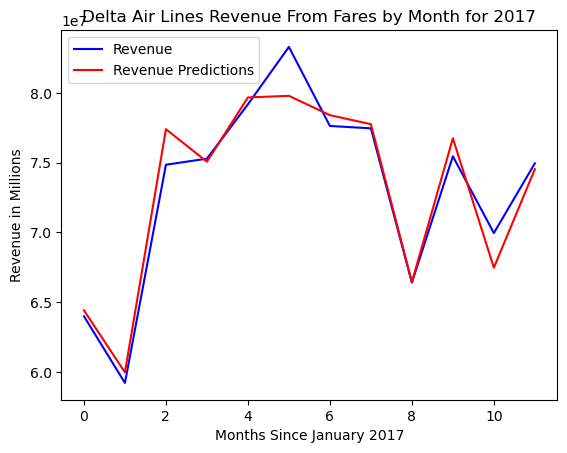

In [25]:
plt.title("Delta Air Lines Revenue From Fares by Month for 2017")

x = data.index
y = data["revenue"].values
plt.plot(x, y, color="blue", label="Revenue")

x = data.index
y = pred
plt.plot(x, y, color="red", label="Revenue Predictions")
plt.xlabel("Months Since January 2017")
plt.ylabel("Revenue in Millions")
plt.legend(loc="upper left")
plt.show()

# V1: Determining If Monthly Inputs Aggregated Quarterly are Correlated to Quarterly PRASM and CASM

## Correlation to Quarterly PRASM

In [26]:
X = quarterly_data[
    [
        "Passenger Volume",
        "RPM",
        "ASM",
        "CPI",
        "Search Activity",
        "AXP Closing Price",
        "Pre-Earnings DAL Closing Price",
    ]
]
Y = list(quarterly_data["PRASM"].values)
model = LinearRegression().fit(X, Y)
score = model.score(X, Y)
prasm_pred = model.predict(X)
print("Coefficient of Determination:", score)
print("Coefficients:", model.coef_)
print("MAE : ", mean_absolute_error(Y, prasm_pred))
print("MSE : ", mean_squared_error(Y, prasm_pred))

Coefficient of Determination: 0.8439679169870438
Coefficients: [ 1.07614436e-06  7.54127364e-07 -1.38191516e-06  4.31825836e-03
 -1.53766046e-02  2.97232878e-02 -2.34750388e-02]
MAE :  0.33693868969425966
MSE :  0.2173136836162946


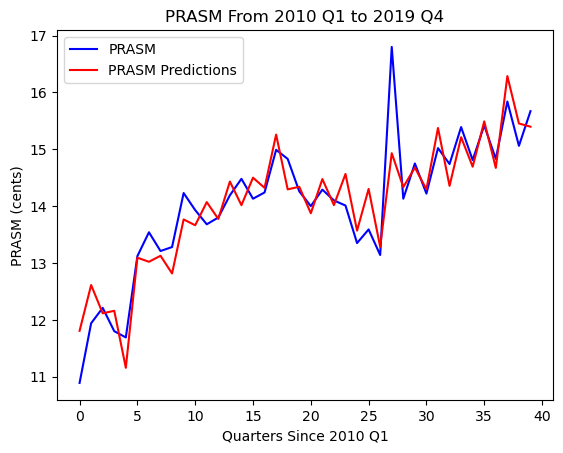

In [27]:
plt.title("PRASM From 2010 Q1 to 2019 Q4")

x = quarterly_data.index
y = quarterly_data["PRASM"].values
plt.plot(x, y, color="blue", label="PRASM")

x = quarterly_data.index
y = prasm_pred
plt.plot(x, y, color="red", label="PRASM Predictions")

plt.xlabel("Quarters Since 2010 Q1")
plt.ylabel("PRASM (cents)")
plt.legend(loc="upper left")
plt.show()

## Correlation to Quarterly CASM

In [28]:
X = quarterly_data[
    ["Passenger Volume", "PPI", "Fuel Price", "Hourly Earnings", "Employees"]
]
Y = list(quarterly_data["CASM"].values)
model = LinearRegression().fit(X, Y)
score = model.score(X, Y)
casm_pred = model.predict(X)
print("Coefficient of Determination:", score)
print("Coefficients:", model.coef_)
print("MAE : ", mean_absolute_error(Y, casm_pred))
print("MSE : ", mean_squared_error(Y, casm_pred))

Coefficient of Determination: 0.6975390741613743
Coefficients: [-5.09834190e-07  4.44693051e-02  9.08904727e-01  9.10315448e-02
  8.41555171e-04]
MAE :  0.44181620245087555
MSE :  0.41913946243383693


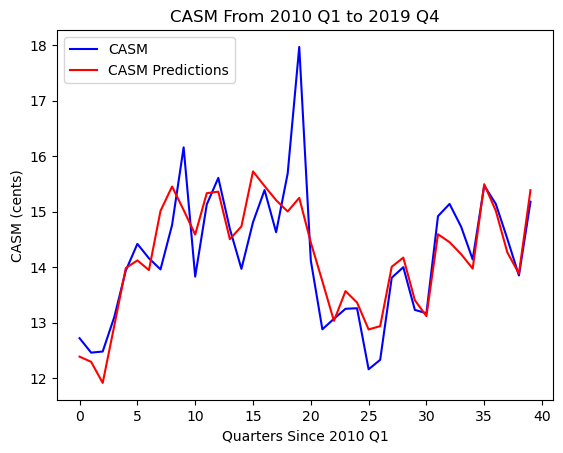

In [29]:
plt.title("CASM From 2010 Q1 to 2019 Q4")

x = quarterly_data.index
y = quarterly_data["CASM"].values
plt.plot(x, y, color="blue", label="CASM")

x = quarterly_data.index
y = casm_pred
plt.plot(x, y, color="red", label="CASM Predictions")

plt.xlabel("Quarters Since 2010 Q1")
plt.ylabel("CASM (cents)")
plt.legend(loc="upper left")
plt.show()

# V2: Predicting Post-Earnings Release DAL Closing Price Using Monthly Inputs Aggregated Quarterly

## Correlation to Post-Earnings Release DAL Closing Price

In [30]:
X = quarterly_data[
    [
        "Passenger Volume",
        "RPM",
        "ASM",
        "CPI",
        "Search Activity",
        "AXP Closing Price",
        "Pre-Earnings DAL Closing Price",
        "PPI",
        "Fuel Price",
        "Hourly Earnings",
        "Employees",
    ]
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
model = LinearRegression()
model.fit(X, Y)
score = model.score(X, Y)
pred = model.predict(X)
print("Coefficient of Determination:", score)
print("Coefficients:", model.coef_)
print("MAE : ", mean_absolute_error(Y, pred))
print("MSE : ", mean_squared_error(Y, pred))

Coefficient of Determination: 0.9942128300832429
Coefficients: [-2.70557362e-06  7.03125903e-07  3.64421472e-07  5.96425683e-02
  5.13745302e-02  1.44626589e-01  7.62369209e-01 -1.57196647e-02
 -3.83691525e+00  6.10465265e-01  2.53985976e-03]
MAE :  1.0223817196717024
MSE :  1.948013326596468


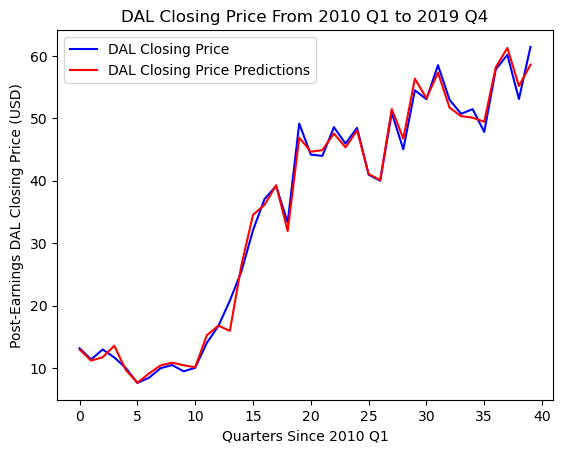

In [31]:
plt.title("DAL Closing Price From 2010 Q1 to 2019 Q4")
x = quarterly_data.index
y = quarterly_data["Post-Earnings DAL Closing Price"].values
plt.plot(x, y, color="blue", label="DAL Closing Price")

x = quarterly_data.index
y = pred
plt.plot(x, y, color="red", label="DAL Closing Price Predictions")

plt.xlabel("Quarters Since 2010 Q1")
plt.ylabel("Post-Earnings DAL Closing Price (USD)")
plt.legend(loc="upper left")
plt.show()

## Prediction of Post-Earnings Release DAL Closing Price

Fold 1:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Test:  index=[25 26 27]
Coefficient of Determination: 0.6742112766318626
Coefficients: [ 5.55072553e-06 -3.87116497e-06  1.19258813e-06 -3.67084808e-02
  2.11666706e-02  1.92723898e-01  7.07327676e-01 -9.70114112e-02
 -2.86989012e-01  0.00000000e+00 -1.22804157e-04]
MAE :  2.571042268654286
MSE :  7.874074532077415


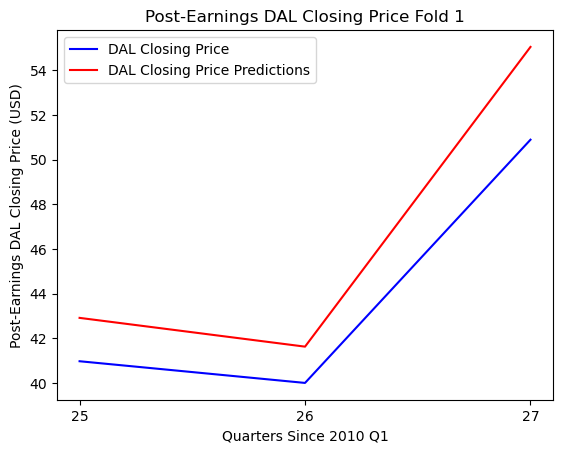



Fold 2:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Test:  index=[28 29 30]
Coefficient of Determination: 0.7550716980502306
Coefficients: [ 2.98141733e-06 -2.42696058e-06  1.02255970e-06  2.18288879e-03
 -0.00000000e+00  1.57304871e-01  7.90339997e-01 -7.37844461e-02
 -5.05342722e-01  0.00000000e+00 -2.18533066e-04]
MAE :  2.042301016558793
MSE :  4.23638332469515


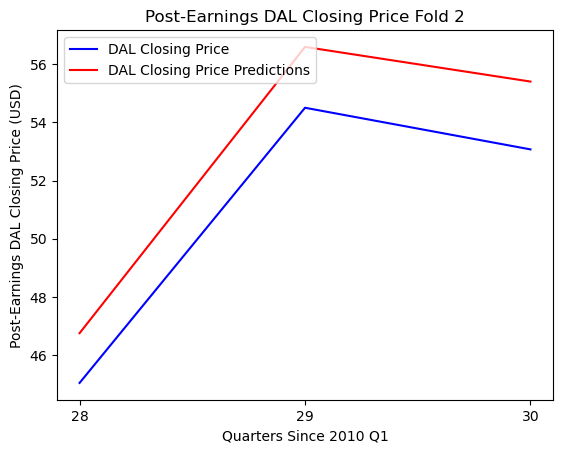



Fold 3:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Test:  index=[31 32 33]
Coefficient of Determination: 0.8460260616541788
Coefficients: [ 2.28872590e-06 -1.95543904e-06  8.17530761e-07  2.11797053e-02
 -1.74270302e-02  1.25487149e-01  8.18239141e-01 -6.88549877e-02
 -4.01407310e-01  0.00000000e+00 -1.32868065e-04]
MAE :  0.9523228902475177
MSE :  1.6498854956646671


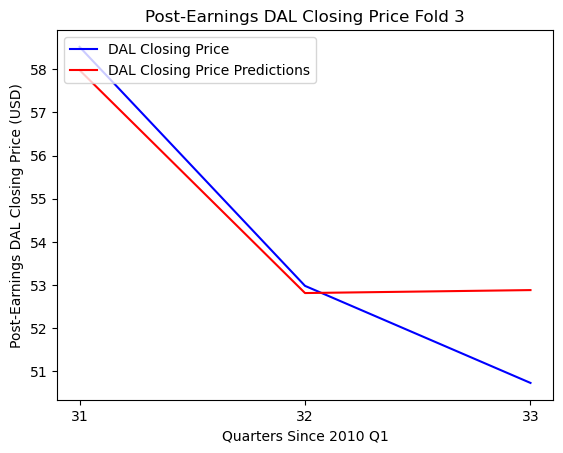



Fold 4:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Test:  index=[34 35 36]
Coefficient of Determination: 0.929318861970361
Coefficients: [ 1.37269121e-06 -1.32834264e-06  5.82366732e-07  3.01818515e-02
 -1.75084269e-02  1.09708092e-01  8.48216625e-01 -7.35955915e-02
 -3.21719837e-01  0.00000000e+00  2.78712357e-04]
MAE :  0.8764671710804421
MSE :  1.2143632083354914


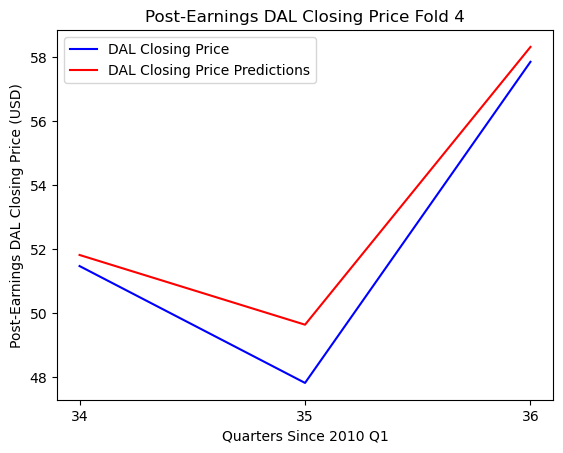



Fold 5:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Test:  index=[37 38 39]
Coefficient of Determination: 0.6203303555055868
Coefficients: [ 1.04659285e-06 -1.13119508e-06  5.84926185e-07  4.11050337e-02
 -3.85751635e-02  1.00411684e-01  8.78094890e-01 -9.14374819e-02
 -4.58364399e-02  0.00000000e+00  4.48161453e-05]
MAE :  2.2551352366054567
MSE :  5.128839108030074


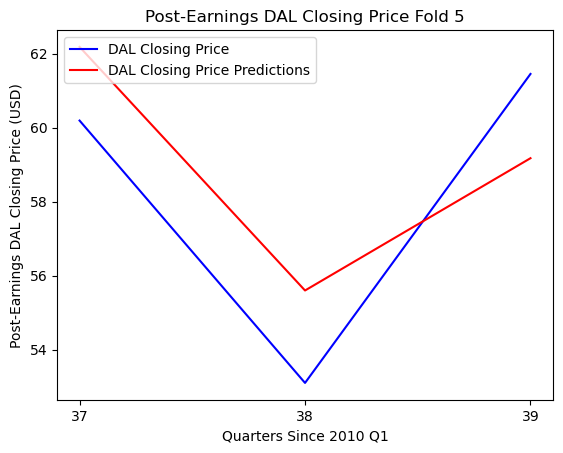

In [32]:
X = quarterly_data[
    [
        "Passenger Volume",
        "RPM",
        "ASM",
        "CPI",
        "Search Activity",
        "AXP Closing Price",
        "Pre-Earnings DAL Closing Price",
        "PPI",
        "Fuel Price",
        "Hourly Earnings",
        "Employees",
    ]
]
Y = quarterly_data[["Post-Earnings DAL Closing Price"]]
tscv = TimeSeriesSplit(test_size=3)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}:")
    print(f"Train: index={train_index}")
    print(f"Test:  index={test_index}")
    train_x = X.loc[train_index]
    train_y = Y.loc[train_index]
    test_x = X.loc[test_index]
    test_y = Y.loc[test_index]
    model = ElasticNet(alpha=0.2, l1_ratio=0.75, max_iter=10000)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
    pred = model.predict(test_x)
    print("Coefficient of Determination:", score)
    print("Coefficients:", model.coef_)
    print("MAE : ", mean_absolute_error(test_y, pred))
    print("MSE : ", mean_squared_error(test_y, pred))
    plt.title(f"Post-Earnings DAL Closing Price Fold {i+1}")
    plt.xticks(test_x.index)
    x = test_x.index
    y = test_y.values
    plt.plot(x, y, color="blue", label="DAL Closing Price")
    x = test_x.index
    y = pred
    plt.plot(x, y, color="red", label="DAL Closing Price Predictions")
    plt.xlabel("Quarters Since 2010 Q1")
    plt.ylabel("Post-Earnings DAL Closing Price (USD)")
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.5)
    plt.legend(loc="upper left")
    plt.show()
    print("\n")

# V3: Feature Selection

## Variance Inflation Factor to Remove Multicollinearity

In [33]:
quarterly_data_copy = quarterly_data.copy()
quarterly_data_copy.rename(
    columns={
        "Passenger Volume": "Vol",
        "Search Activity": "Activity",
        "AXP Closing Price": "AXP",
        "Pre-Earnings DAL Closing Price": "PreDAL",
        "Fuel Price": "Fuel_Price",
        "Hourly Earnings": "Earnings",
        "Post-Earnings DAL Closing Price": "PostDAL",
    },
    inplace=True,
)
Y, X = dmatrices(
    "PostDAL ~ Vol+RPM+ASM+CPI+Activity+AXP+PreDAL+PPI+Fuel_Price+Earnings+Employees",
    data=quarterly_data_copy,
    return_type="dataframe",
)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

      Variable           VIF
0    Intercept  38248.413944
1          Vol    247.739339
2          RPM    241.913926
3          ASM    113.411255
4          CPI      4.606993
5     Activity     26.500770
6          AXP     17.070406
7       PreDAL     32.717603
8          PPI      5.890720
9   Fuel_Price     15.636875
10    Earnings     47.352635
11   Employees     47.409314


In [34]:
Y, X = dmatrices(
    "PostDAL ~ ASM+CPI+Activity+AXP+PreDAL+PPI+Fuel_Price+Earnings+Employees",
    data=quarterly_data_copy,
    return_type="dataframe",
)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

     Variable           VIF
0   Intercept  24185.804282
1         ASM      3.273820
2         CPI      3.359830
3    Activity     25.720919
4         AXP     16.028479
5      PreDAL     31.714498
6         PPI      5.739245
7  Fuel_Price     14.063872
8    Earnings     25.471114
9   Employees     34.977850


In [35]:
Y, X = dmatrices(
    "PostDAL ~ ASM+CPI+Activity+AXP+PPI+Fuel_Price",
    data=quarterly_data_copy,
    return_type="dataframe",
)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

     Variable          VIF
0   Intercept  2038.512926
1         ASM     2.055606
2         CPI     2.114566
3    Activity     6.179873
4         AXP     4.798807
5         PPI     3.949253
6  Fuel_Price     4.608006


## Coefficient Significance Tests to Determine Causality

In [36]:
X = quarterly_data[
    [
        "Passenger Volume",
        "RPM",
        "ASM",
        "CPI",
        "Search Activity",
        "AXP Closing Price",
        "Pre-Earnings DAL Closing Price",
        "PPI",
        "Fuel Price",
        "Hourly Earnings",
        "Employees",
    ]
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              1938.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):                    1.85e-38
Time:                        14:57:58   Log-Likelihood:                         -71.637
No. Observations:                  40   AIC:                                      165.3
Df Residuals:                      29   BIC:                                      183.9
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

## Optimizing AIC and Verifying Causality

In [37]:
def generate_sublists(lst):
    if not lst:
        return [[]]
    first_element = lst[0]
    rem_elements = lst[1:]
    subsets_without_first = generate_sublists(rem_elements)
    subsets_with_first = [
        ([first_element] + subset) for subset in subsets_without_first
    ]
    all_subsets = subsets_with_first + subsets_without_first
    return all_subsets


inputs = [
    "Passenger Volume",
    "RPM",
    "ASM",
    "CPI",
    "Search Activity",
    "AXP Closing Price",
    "Pre-Earnings DAL Closing Price",
    "PPI",
    "Fuel Price",
    "Hourly Earnings",
    "Employees",
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"])
sublists = generate_sublists(inputs)
sublists.remove([])

In [38]:
inputs = []
aic = []
for l in sublists:
    X = quarterly_data[l]
    Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
    model = sm.OLS(Y, X)
    results = model.fit()
    inputs.append(l)
    aic.append(results.aic)

aic.index(min(aic)), min(aic), inputs[aic.index(min(aic))]

(1611,
 156.0103690290557,
 ['ASM',
  'CPI',
  'AXP Closing Price',
  'Pre-Earnings DAL Closing Price',
  'Fuel Price'])

In [39]:
X = quarterly_data[
    ["ASM", "CPI", "AXP Closing Price", "Pre-Earnings DAL Closing Price", "Fuel Price"]
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              4806.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):                    1.36e-48
Time:                        14:58:22   Log-Likelihood:                         -73.005
No. Observations:                  40   AIC:                                      156.0
Df Residuals:                      35   BIC:                                      164.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [40]:
X = quarterly_data[
    ["CPI", "AXP Closing Price", "Pre-Earnings DAL Closing Price", "Fuel Price"]
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5571.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):                    1.03e-49
Time:                        14:58:26   Log-Likelihood:                         -75.072
No. Observations:                  40   AIC:                                      158.1
Df Residuals:                      36   BIC:                                      164.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [47]:
X = quarterly_data[
    ["CPI", "AXP Closing Price", "Pre-Earnings DAL Closing Price", "Fuel Price"]
]
Y = list(quarterly_data["Post-Earnings DAL Closing Price"].values)
model = LinearRegression()
model.fit(X, Y)
score = model.score(X, Y)
pred = model.predict(X)
print("Coefficient of Determination:", score)
print("Coefficients:", model.coef_)
print("MAE : ", mean_absolute_error(Y, pred))
print("MSE : ", mean_squared_error(Y, pred))

Coefficient of Determination: 0.9929268564292418
Coefficients: [ 0.03569097  0.1128773   0.84052234 -2.65764663]
MAE :  1.098394511707856
MSE :  2.3808835985393246


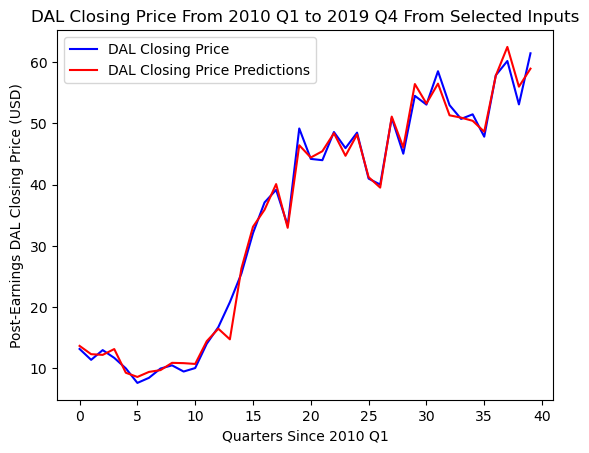

In [48]:
plt.title("DAL Closing Price From 2010 Q1 to 2019 Q4 From Selected Inputs")
x = quarterly_data.index
y = quarterly_data["Post-Earnings DAL Closing Price"].values
plt.plot(x, y, color="blue", label="DAL Closing Price")

x = quarterly_data.index
y = pred
plt.plot(x, y, color="red", label="DAL Closing Price Predictions")

plt.xlabel("Quarters Since 2010 Q1")
plt.ylabel("Post-Earnings DAL Closing Price (USD)")
plt.legend(loc="upper left")
plt.show()

Fold 1:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Test:  index=[25 26 27]
Coefficient of Determination: 0.980012594192014
Coefficients: [ 0.01645295  0.11268968  0.88325076 -1.40933483]
MAE :  0.6932095441587123
MSE :  0.4830809409480959


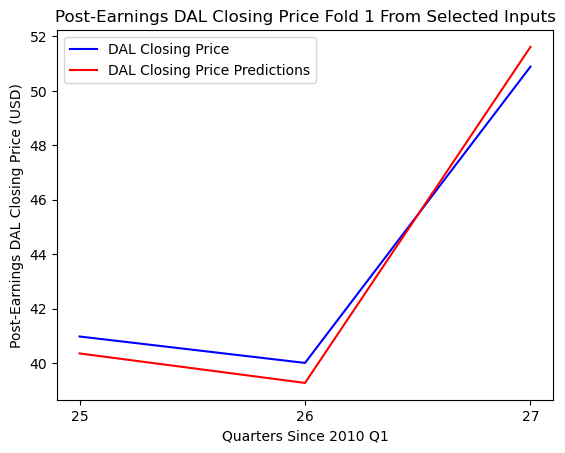



Fold 2:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Test:  index=[28 29 30]
Coefficient of Determination: 0.8757918824524202
Coefficients: [ 0.0219663   0.10063649  0.89595274 -1.31118273]
MAE :  1.3570140762705165
MSE :  2.1483560445303493


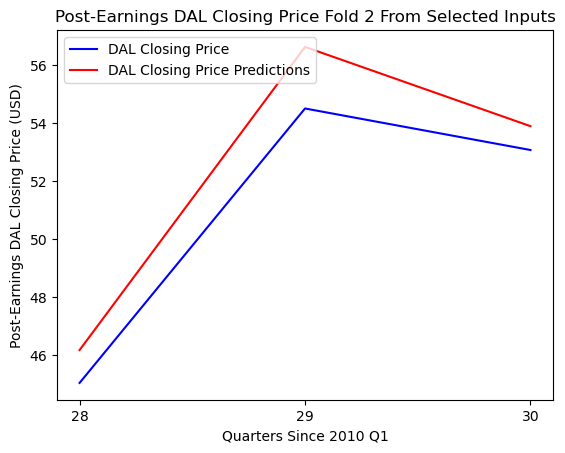



Fold 3:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Test:  index=[31 32 33]
Coefficient of Determination: 0.8664416130758328
Coefficients: [ 0.02380127  0.09011879  0.90049689 -1.06868405]
MAE :  1.1197736505535854
MSE :  1.4311256033189164


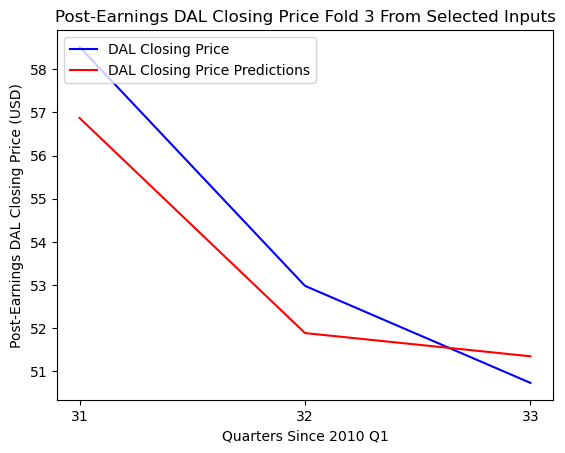



Fold 4:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Test:  index=[34 35 36]
Coefficient of Determination: 0.926335489977936
Coefficients: [ 0.0140147   0.09183374  0.90673853 -0.84020974]
MAE :  0.9295430702509174
MSE :  1.2656201247544117


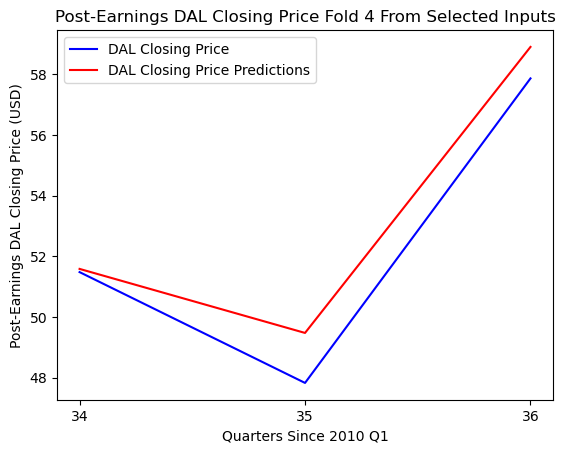



Fold 5:
Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Test:  index=[37 38 39]
Coefficient of Determination: 0.6158114520994926
Coefficients: [ 0.02064747  0.07433365  0.92807957 -0.59966297]
MAE :  2.187557022831198
MSE :  5.18988356826194


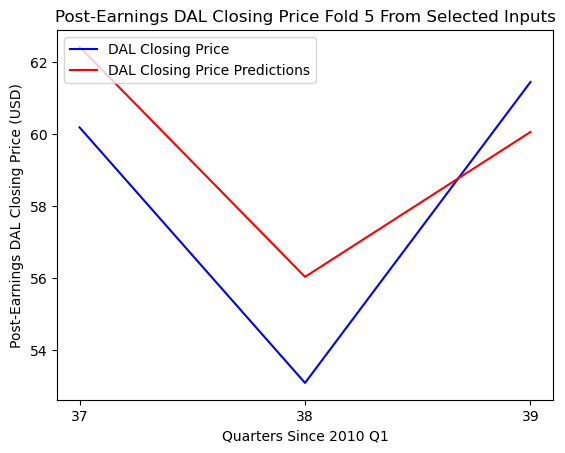

In [49]:
X = quarterly_data[
    ["CPI", "AXP Closing Price", "Pre-Earnings DAL Closing Price", "Fuel Price"]
]
Y = quarterly_data[["Post-Earnings DAL Closing Price"]]
tscv = TimeSeriesSplit(test_size=3)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}:")
    print(f"Train: index={train_index}")
    print(f"Test:  index={test_index}")
    train_x = X.loc[train_index]
    train_y = Y.loc[train_index]
    test_x = X.loc[test_index]
    test_y = Y.loc[test_index]
    model = ElasticNet(alpha=0.2, l1_ratio=0.75, max_iter=10000)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
    pred = model.predict(test_x)
    print("Coefficient of Determination:", score)
    print("Coefficients:", model.coef_)
    print("MAE : ", mean_absolute_error(test_y, pred))
    print("MSE : ", mean_squared_error(test_y, pred))
    plt.title(f"Post-Earnings DAL Closing Price Fold {i+1} From Selected Inputs")
    plt.xticks(test_x.index)
    x = test_x.index
    y = test_y.values
    plt.plot(x, y, color="blue", label="DAL Closing Price")
    x = test_x.index
    y = pred
    plt.plot(x, y, color="red", label="DAL Closing Price Predictions")
    plt.xlabel("Quarters Since 2010 Q1")
    plt.ylabel("Post-Earnings DAL Closing Price (USD)")
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.5)
    plt.legend(loc="upper left")
    plt.show()
    print("\n")